In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle 
import math
import random as r
import json
import re
import ast

import openai
import backoff

from sklearn.metrics import classification_report, recall_score, precision_score, f1_score, accuracy_score
import matplotlib.pyplot as plt

In [2]:
TEST_DIR = '../../data/multi_label_test'
CATEGORIES = ['1', '1.1', '1.2', '1.3', 
              '2', '2.1', '2.2', '2.3', '2.4', '2.5', 
              '3', '3.1', '3.2', '3.3', '3.4', '3.5', 
              '4', '4.1', '4.2', 
              '5', '5.1', '5.2', '5.3', '5.4']

@backoff.on_exception(backoff.expo,
    (
        openai.APIError,
        openai.APITimeoutError,
        openai.RateLimitError,
        openai.APIConnectionError,
    ),
    max_tries=10)
def get_chat_response(messages, model, temperature, max_tokens, n_samples=1):
    return openai.chat.completions.create(
        model=model, 
        messages=messages, 
        temperature=temperature,
        max_tokens=max_tokens,
        n = n_samples
    )

### Raw Data Cleanup
- combined paragraphs.csv and dictionary.txt
- dropped 'position' column
- converted dictionary.txt to dictionaries with format {'#' : 0/1}

In [3]:
def make_ann_csv(overwrite=False):
    if os.path.exists(os.path.join(TEST_DIR, "ann.csv")) and not overwrite:
        return
    
    multi_labeled = pd.read_csv(os.path.join(TEST_DIR, "paragraphs.csv"))
    with open(os.path.join(TEST_DIR, "dictionary.txt")) as dict_file:
        multi_label_dict = json.loads((dict_file.read()).replace("'", '"'))

    multi_labeled.drop("position", inplace=True, axis=1)
    multi_labeled.drop(multi_labeled.columns[0], inplace=True, axis=1)
    new_labels = []
    for id in multi_labeled['id']:
        new_dict = {}
        for cat in CATEGORIES:
            new_dict[cat] = 1 if multi_label_dict[str(id)]['taxlabel_' + cat.replace('.', '_')] == 'on' else 0
        new_labels.append(new_dict)
    multi_labeled['annotations'] = new_labels

    multi_labeled.to_csv(os.path.join(TEST_DIR, "ann.csv"), index=False)

make_ann_csv()

In [5]:
def make_gpt_ann_csv(reset=False):
    if os.path.exists(os.path.join(TEST_DIR, "gpt_ann.csv")) and not reset:
        return
    
    df = pd.read_csv(os.path.join(TEST_DIR, "ann.csv"))
    df.drop('annotations', inplace=True, axis=1)
    LEN = len(df)

    df['gpt_ann_txt'] = [None] * LEN
    df['gpt_ann'] = [None] * LEN

    df.to_csv(os.path.join(TEST_DIR, 'gpt_ann.csv'), index=False)

def make_gpt_ann_individual_csv(reset=False):
    if os.path.exists(os.path.join(TEST_DIR, "gpt_ann_indiv.csv")) and not reset:
        return
    
    df = pd.read_csv(os.path.join(TEST_DIR, "ann.csv"))
    df.drop('annotations', inplace=True, axis=1)
    LEN = len(df)

    df['gpt_ann_txt'] = [None] * LEN
    df['gpt_ann'] = [None] * LEN

    df.to_csv(os.path.join(TEST_DIR, 'gpt_ann_indiv.csv'), index=False)

make_gpt_ann_csv()
make_gpt_ann_individual_csv()

### Prompt GPT
- stores raw response, parsed response, and final output ()

In [36]:
with open('../prompt.txt', 'r') as prompt_file:
    prompt = prompt_file.read()

openai.api_key = os.getenv("OPENAI_KEY_VAX_MISINFO")
MODEL = "gpt-4-1106-preview"
TEMP = 0.0
MAX_TOKENS = 1024
PROMPT = prompt

df = pd.read_csv(os.path.join(TEST_DIR, "gpt_ann.csv"))
ids = df["id"]
paragraphs = df["content"]
LEN = len(df)

gpt_ann_txt = list(df['gpt_ann_txt'])
for i, (id, paragraph) in tqdm(enumerate(zip(ids, paragraphs))):
    if not pd.isnull(gpt_ann_txt[i]):
        continue
    message=[{"role": "user", "content": "{}{}".format(PROMPT, paragraph)}]
    response = get_chat_response(message, MODEL, TEMP, MAX_TOKENS).choices[0].message.content
    gpt_ann_txt[i] = response
    df['gpt_ann_txt'] = gpt_ann_txt
    
    df.to_csv(os.path.join(TEST_DIR, 'gpt_ann.csv'), index=False)

200it [00:00, 1941807.41it/s]


In [14]:
def parse_txt(txt):
    pattern = r"VaxConcerns_(\d*\.?\d*):\s*\[?(\d*\.?\d*)\]?"
    matches = re.findall(pattern, txt)
    matches = [match for match in matches if match[1].isnumeric()]
    return dict([(match[0], int(match[1]))for match in matches])

def process_response(id, raw_response):
    output = dict([(cat, 0) for cat in CATEGORIES])
    for key in raw_response.keys():
        if key not in output:
            print("id {}: GPT should not have returned this key: {}".format(id, key))
            # print("raw_response text:\n{}".format(txt))
            continue
        if raw_response[key] == 1 and "." in key and raw_response[key[0]] == 0:
            output[key[0]] = 1
            print("id {}: Had to label parent label of {} as 1".format(id, key))
        output[key] = raw_response[key]
    if len(output) != len(raw_response):
        print("id {}: GPT does not have correct number of labels: GPT gave {} labels, should be 24".format(id, len(raw_response)))
    return output

In [15]:
df = pd.read_csv(os.path.join(TEST_DIR, "gpt_ann.csv"))
ids = df["id"]

gpt_ann_txt = list(df['gpt_ann_txt'])
gpt_ann = list(df['gpt_ann'])
for i, (id, response) in enumerate(zip(ids, gpt_ann_txt)):
    if pd.isnull(response):
        continue

    raw_output = parse_txt(response)
    processed_output = process_response(id, raw_output)

    gpt_ann[i] = processed_output

df['gpt_ann_txt'] = gpt_ann_txt
df['gpt_ann'] = gpt_ann

df.to_csv(os.path.join(TEST_DIR, 'gpt_ann.csv'), index=False)

id 20386: Had to label parent label of 2.5 as 1
id 22218: Had to label parent label of 1.2 as 1
id 28901: Had to label parent label of 5.4 as 1
id 31528: Had to label parent label of 1.2 as 1
id 42253: Had to label parent label of 5.3 as 1
id 49925: Had to label parent label of 1.2 as 1
id 58357: Had to label parent label of 1.3 as 1
id 68781: Had to label parent label of 2.2 as 1
id 77777: Had to label parent label of 2.1 as 1
id 77777: Had to label parent label of 3.5 as 1
id 79655: Had to label parent label of 1.2 as 1
id 79669: Had to label parent label of 3.4 as 1
id 80103: Had to label parent label of 2.1 as 1
id 85332: Had to label parent label of 5.3 as 1
id 107971: Had to label parent label of 1.3 as 1
id 109975: GPT does not have correct number of labels: GPT gave 21 labels, should be 24
id 110002: Had to label parent label of 3.4 as 1
id 110002: Had to label parent label of 5.1 as 1
id 110958: GPT does not have correct number of labels: GPT gave 0 labels, should be 24


### Prompt GPT with Separate Labels and Confidence (100 samples)

In [3]:
with open('../prompt_2.txt', 'r') as prompt_file:
    prompt_indiv = prompt_file.read()

openai.api_key = os.getenv("OPENAI_KEY_VAX_MISINFO")
MODEL = "gpt-4-1106-preview"
TEMP_INDIV = 1.0
MAX_TOKENS_INDIV = 3
PROMPT_INDIV = prompt_indiv
N_SAMPLES = 100

In [16]:
df = pd.read_csv(os.path.join(TEST_DIR, "gpt_ann_indiv.csv"))
ids = df["id"]
paragraphs = df["content"]
LEN = len(df)

gpt_ann_txt = list(df['gpt_ann_txt'])
for i, (id, paragraph) in tqdm(enumerate(zip(ids, paragraphs))):
    if not pd.isnull(gpt_ann_txt[i]):
        continue
    full_ann = []
    for cat in CATEGORIES:
        message=[{"role": "user", "content": PROMPT_INDIV.format(cat, paragraph)}]
        responses = None
        while responses is None:
            try:
                responses = [re.findall('\d', choice.message.content)[0] for choice in get_chat_response(message, MODEL, TEMP_INDIV, MAX_TOKENS_INDIV, N_SAMPLES).choices]
            except:
                print('trying again for {}...'.format(cat))
                pass
        full_ann.append(responses)
    gpt_ann_txt[i] = str(full_ann)
    df['gpt_ann_txt'] = gpt_ann_txt
    df.to_csv(os.path.join(TEST_DIR, 'gpt_ann_indiv.csv'), index=False)

154it [01:07,  2.28it/s]

trying again for 5...
trying again for 5...
trying again for 5...


183it [02:20,  1.14it/s]

trying again for 2...
trying again for 2...
trying again for 2...
trying again for 2.3...
trying again for 3.5...
trying again for 4.1...
trying again for 4.1...
trying again for 5...
trying again for 5...
trying again for 5...
trying again for 5...
trying again for 5.1...
trying again for 5.4...


200it [05:13,  1.57s/it]


In [37]:
def get_label_scores(response):
    for i, label in enumerate(response):
        response[i] = sum([int(vote) for vote in label]) / len(label)
    return response

df = pd.read_csv(os.path.join(TEST_DIR, "gpt_ann_indiv.csv"))
ids = df["id"]
gpt_ann_txt = df['gpt_ann_txt'].to_list()
gpt_ann = df['gpt_ann'].to_list()
for i, (id, response) in enumerate(zip(ids, gpt_ann_txt)):
    if pd.isnull(response):
        continue
    response = ast.literal_eval(response)
    gpt_ann[i] = dict(zip(CATEGORIES, get_label_scores(response)))

df['gpt_ann_txt'] = gpt_ann_txt
df['gpt_ann'] = gpt_ann

df.to_csv(os.path.join(TEST_DIR, 'gpt_ann_indiv.csv'), index=False)

### Evaluate GPT Annotations

In [36]:
human_ann = pd.read_csv(os.path.join(TEST_DIR, "ann.csv"))['annotations'].to_list()
human_ann = [json.loads(d.replace("'", '"')) for d in human_ann]
human_ann = [[d[cat] for cat in CATEGORIES] for d in human_ann]

gpt_ann = pd.read_csv(os.path.join(TEST_DIR, "gpt_ann.csv"))['gpt_ann'].to_list()
gpt_ann = [json.loads(d.replace("'", '"')) for d in gpt_ann]
gpt_ann = [[d[cat] for cat in CATEGORIES] for d in gpt_ann]

gpt_ann_indiv = pd.read_csv(os.path.join(TEST_DIR, "gpt_ann_indiv.csv"))['gpt_ann'].to_list()
gpt_ann_indiv = [json.loads(d.replace("'", '"')) for d in gpt_ann_indiv]
gpt_ann_indiv = [[d[cat] for cat in CATEGORIES] for d in gpt_ann_indiv]

In [37]:
index = [i for i, h in enumerate(human_ann) if sum(h) != 0]
human_ann = [human_ann[i] for i in index]
gpt_ann = [gpt_ann[i] for i in index]
gpt_ann_indiv = [gpt_ann_indiv[i] for i in index]

In [43]:
print(classification_report(human_ann, gpt_ann, target_names=CATEGORIES))

              precision    recall  f1-score   support

           1       0.67      0.63      0.65        19
         1.1       1.00      0.25      0.40         8
         1.2       0.73      0.67      0.70        12
         1.3       0.00      0.00      0.00         0
           2       1.00      0.78      0.88        18
         2.1       1.00      0.69      0.82        13
         2.2       0.00      0.00      0.00         0
         2.3       1.00      1.00      1.00         1
         2.4       1.00      0.50      0.67         2
         2.5       1.00      1.00      1.00         2
           3       0.92      0.72      0.81        47
         3.1       0.00      0.00      0.00         0
         3.2       1.00      1.00      1.00        11
         3.3       0.77      0.29      0.43        34
         3.4       0.25      0.33      0.29         3
         3.5       0.12      0.50      0.20         2
           4       0.88      0.70      0.78        10
         4.1       1.00    

/Users/christopherli/anaconda3/envs/vax_trends/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/christopherli/anaconda3/envs/vax_trends/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/christopherli/anaconda3/envs/vax_trends/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

In [66]:
gpt_ann_indiv_clamped = [[1 if score > 0.85 else 0 for score in ann] for ann in gpt_ann_indiv]
print(classification_report(human_ann, gpt_ann_indiv_clamped, target_names=CATEGORIES))

              precision    recall  f1-score   support

           1       0.34      0.89      0.49        19
         1.1       0.67      0.50      0.57         8
         1.2       0.36      0.75      0.49        12
         1.3       0.00      0.00      0.00         0
           2       0.71      0.28      0.40        18
         2.1       0.86      0.46      0.60        13
         2.2       0.00      0.00      0.00         0
         2.3       0.33      1.00      0.50         1
         2.4       0.33      1.00      0.50         2
         2.5       0.67      1.00      0.80         2
           3       0.86      0.79      0.82        47
         3.1       0.00      0.00      0.00         0
         3.2       0.62      0.91      0.74        11
         3.3       0.81      0.50      0.62        34
         3.4       0.20      0.67      0.31         3
         3.5       0.05      0.50      0.10         2
           4       0.37      0.70      0.48        10
         4.1       0.67    

/Users/christopherli/anaconda3/envs/vax_trends/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/christopherli/anaconda3/envs/vax_trends/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/christopherli/anaconda3/envs/vax_trends/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

In [63]:
precisions = []
for cutoff in np.arange(0.0, 1.0, 0.01):
    gpt_ann_indiv_clamped = [[1 if score >= cutoff else 0 for score in ann] for ann in gpt_ann_indiv]
    precisions.append(precision_score(human_ann, gpt_ann_indiv_clamped, average='samples', zero_division=0))

recalls = []
for cutoff in np.arange(0.0, 1.0, 0.01):
    gpt_ann_indiv_clamped = [[1 if score >= cutoff else 0 for score in ann] for ann in gpt_ann_indiv]
    recalls.append(recall_score(human_ann, gpt_ann_indiv_clamped, average='samples', zero_division=0))

f1s = []
for cutoff in np.arange(0.0, 1.0, 0.01):
    gpt_ann_indiv_clamped = [[1 if score >= cutoff else 0 for score in ann] for ann in gpt_ann_indiv]
    f1s.append(f1_score(human_ann, gpt_ann_indiv_clamped, average='samples', zero_division=0))

i = np.argmax(f1s)
print(0.01 * i, f1s[i])

0.86 0.5063661454286454


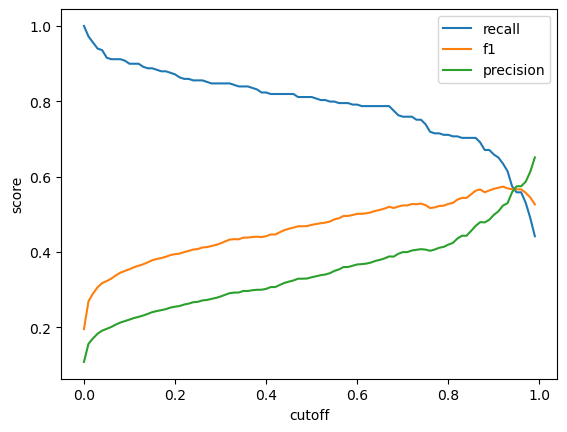

In [53]:
# precision_score_85_i = np.argmin(np.abs(np.array(precision_scores) - 0.85))
cutoffs = np.arange(0.0, 1.0, 0.01)
plt.plot(cutoffs, recalls, label='recall')
plt.plot(cutoffs, f1s, label='f1')
plt.plot(cutoffs, precisions, label='precision')
plt.xlabel('cutoff')
plt.ylabel('score')
plt.legend()
# plt.vlines(x=thresholds[precision_score_85_i], ymin=0, ymax=1, colors='purple')
plt.show()
# print(thresholds[precision_score_85_i])